# ANN to Predict Subject
Using modal representation, can we tell which subject it came from with DMD modes? 

- w/ 100 modes


Setup: Javascript and ipynb stuff

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

## Load Functions

In [3]:
from fastai.vision import *
import os
import numpy as np
import pandas as pd
import pickle

In [4]:
path=pathlib.Path('/media/tris/tris_files/github/SysID_EEGdynamics/src/data/preprocessed/DMD_DEAP')
path

PosixPath('/media/tris/tris_files/github/SysID_EEGdynamics/src/data/preprocessed/DMD_DEAP')

## Load Original Data Labels

In [5]:
df = pd.read_csv(path/'labels_proc.csv') #load labels
df.tail()

,file_name,subject_label
1275,S32T36,32
1276,S32T37,32
1277,S32T38,32
1278,S32T39,32
1279,S32T40,32


## Data loader

In [6]:
src = (ImageList.from_csv(path, 'labels_proc.csv', folder='heatmaps', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(cols=['subject_label'],label_cls=CategoryList))

In [7]:
tfms=[]

In [8]:
data = (src.transform(tfms, size=200)
        .databunch(bs=4).normalize())

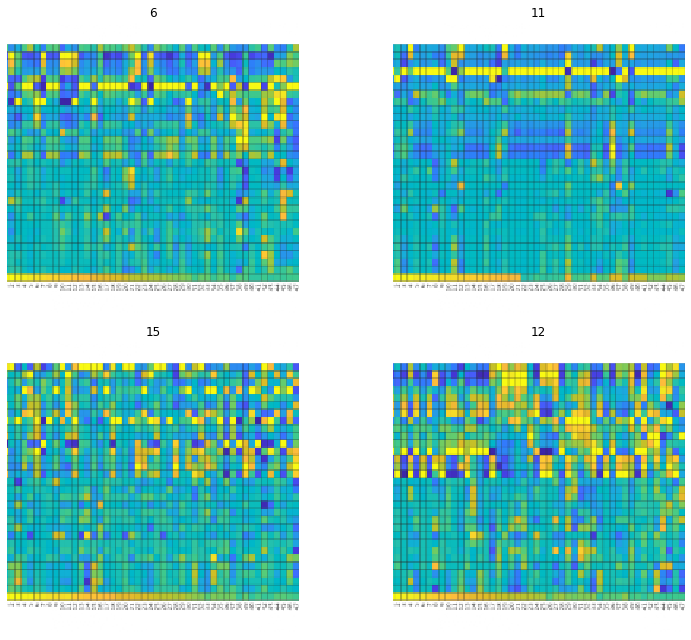

In [17]:
data.show_batch(rows=4, figsize=(12,9))

## Setup Network

In [18]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [19]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 100, 100]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 100, 100]       128        True      
______________________________________________________________________
ReLU                 [64, 100, 100]       0          False     
______________________________________________________________________
MaxPool2d            [64, 50, 50]         0          False     
______________________________________________________________________
Conv2d               [64, 50, 50]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 50, 50]         128        True      
______________________________________________________________________
ReLU                 [64, 50, 50]         0          False     
___________________________________________________

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


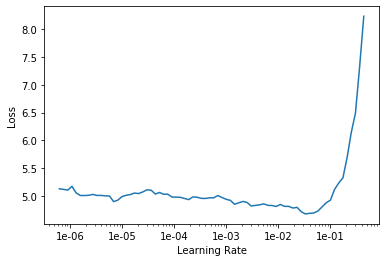

In [20]:
learn.lr_find()
learn.recorder.plot()

## Train last layers

In [21]:
lr = 1e-2
learn.fit_one_cycle(8, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.536157,1.074457,0.679688,00:14
1,2.374674,1.321299,0.660156,00:13
2,2.592619,0.885625,0.796875,00:13
3,1.684003,0.572250,0.839844,00:13
4,1.363495,0.359709,0.894531,00:14
5,0.894190,0.242512,0.937500,00:14
6,0.707357,0.180561,0.960938,00:13
7,0.540591,0.177534,0.941406,00:13


In [22]:
learn.data.stats

[tensor([0.3773, 0.7236, 0.6859]), tensor([0.3686, 0.1714, 0.2534])]

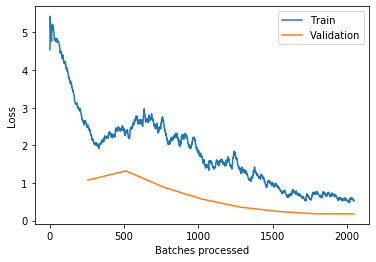

In [23]:
learn.recorder.plot_losses()

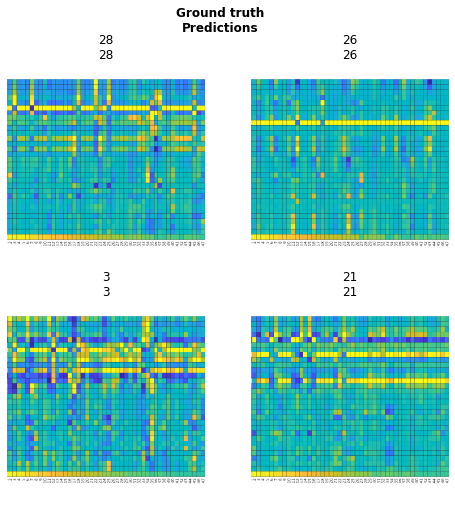

In [24]:
learn.show_results()

## Train the whole network

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


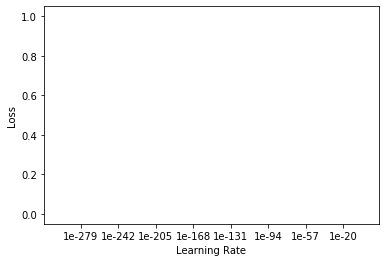

In [25]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [26]:
lr = 1e-4
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.505400,0.146172,0.949219,00:14
1,0.445297,0.160454,0.949219,00:14
2,0.677470,0.150520,0.960938,00:14
3,0.404457,0.132734,0.957031,00:13


# Now allow images to be large

In [27]:
data = (src.transform(tfms, size=512)
        .databunch(bs=4).normalize())

In [28]:
learn.data=data

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


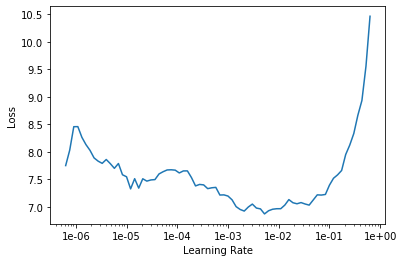

In [29]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [30]:
lr = 1e-3
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,4.223134,1.800514,0.558594,00:24
1,3.402096,1.397623,0.621094,00:24
2,1.700957,0.290054,0.906250,00:25
3,1.337422,0.203771,0.945312,00:24


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


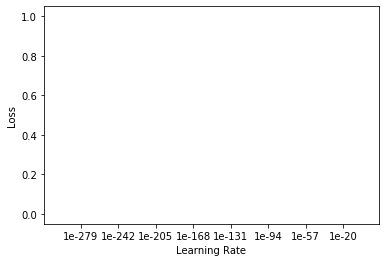

In [31]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [32]:
lr = 1e-6
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.139876,0.185416,0.945312,00:24


## Interpret and Results

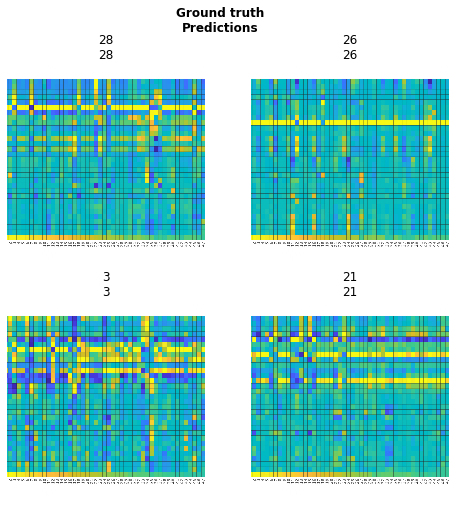

In [33]:
learn.show_results()

In [36]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

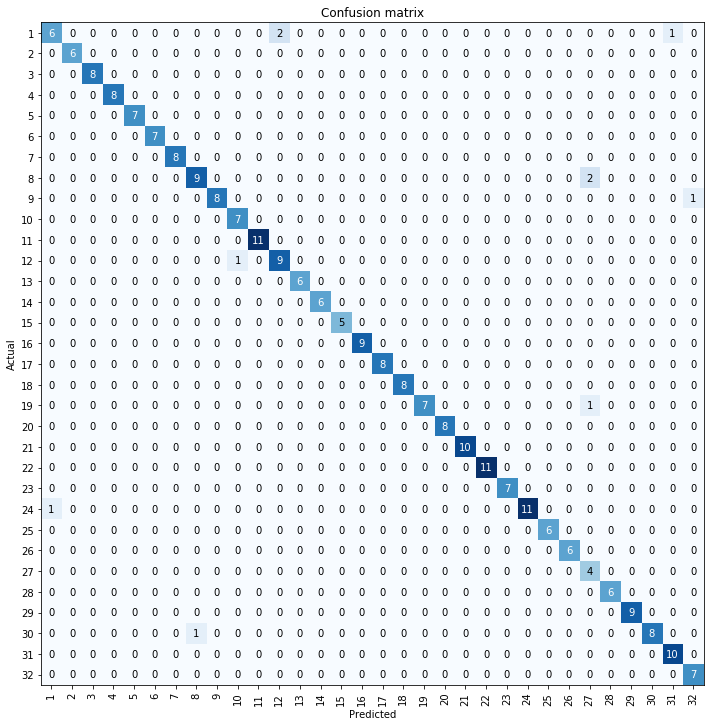

In [36]:
interp.plot_confusion_matrix(figsize=(10,10))

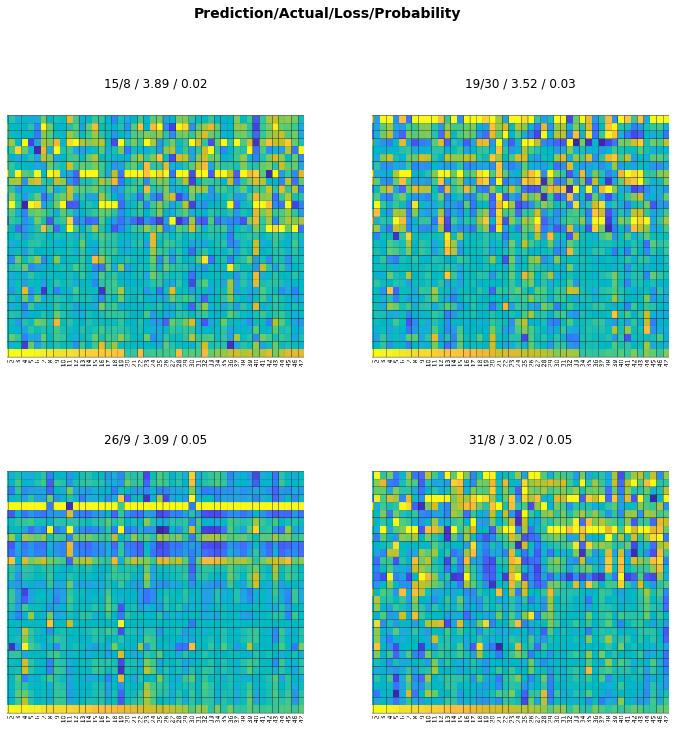

In [37]:
interp.plot_top_losses(4)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,2.394015,0.550826,0.843750,01:06


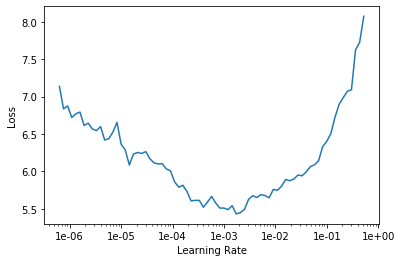

In [71]:
data = (src.transform(tfms, size=1024)
        .databunch(bs=4).normalize())
learn.data=data
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()


In [108]:
learn.fit_one_cycle(1, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.460531,0.151783,0.957031,01:06


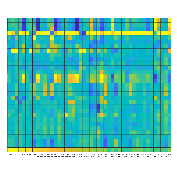

In [226]:
idx=100
x,y = data.valid_ds[idx]
x.show()

In [227]:
m = learn.model.eval();
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [228]:
from fastai.callbacks.hooks import *

In [229]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [230]:
hook_a,hook_g = hooked_backward()

In [231]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 32, 32])

In [232]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([32, 32])

In [233]:
def show_heatmap(hm,filename):
    fig,ax = plt.subplots(figsize=(10,10))
    ax.set_title('DMD Focus Map', fontsize=20)
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.7, extent=(-5*2,520*2,480*2,20*2),
              interpolation='bilinear', cmap='magma');
    plt.savefig(filename, dpi=600,bbox_inches='tight')

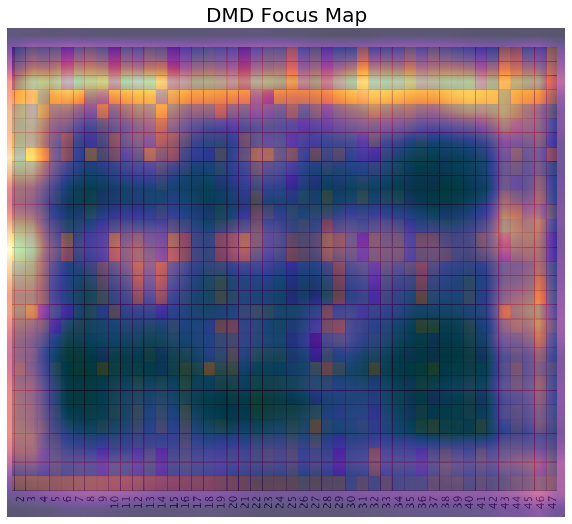

In [234]:
show_heatmap(avg_acts,'DMD_focus.png')